In [ ]:
!pip install sphinx
!pip install pykeops[colab] > install.log

from pykeops.numpy import LazyTensor
from pykeops.numpy.cluster import cluster_ranges_centroids
from pykeops.numpy.cluster import from_matrix
import pykeops.config
import numpy as np


In [ ]:
import numpy as np

from pykeops.numpy import Genred, default_dtype, KernelSolve
from pykeops.numpy.cluster import swap_axes as np_swap_axes
import pykeops.config


class numpytools:
    norm = np.linalg.norm
    arraysum = np.sum
    exp = np.exp
    log = np.log
    Genred = Genred
    KernelSolve = KernelSolve
    swap_axes = np_swap_axes
    arraytype = np.ndarray
    float_types = [float, np.float16, np.float32, np.float64]

    @staticmethod
    def is_tensor(x):
        return isinstance(x, np.ndarray)

    @staticmethod
    def copy(x):
        return np.copy(x)

    @staticmethod
    def eq(x, y):
        return np.equal(x, y)

    @staticmethod
    def transpose(x):
        return x.T

    @staticmethod
    def permute(x, *args):
        return x.transpose(*args)

    @staticmethod
    def contiguous(x):
        return np.ascontiguousarray(x)

    @staticmethod
    def numpy(x):
        return x

    @staticmethod
    def tile(*args):
        return np.tile(*args)

    @staticmethod
    def solve(*args):
        return np.linalg.solve(*args)

    @staticmethod
    def size(x):
        return x.size

    @staticmethod
    def view(x, s):
        return np.reshape(x, s)

    @staticmethod
    def long(x):
        return x.astype("int64")

    @staticmethod
    def dtype(x):
        return x.dtype.name

    @staticmethod
    def detect_complex(x):
        if type(x) == list:
            return any(type(v) == complex for v in x)
        elif type(x) == np.ndarray:
            return np.iscomplexobj(x)
        else:
            return type(x) == complex

    @staticmethod
    def view_as_complex(x):
        if x.dtype == "float32":
            return x.view("complex64")
        elif x.dtype == "float64":
            return x.view("complex128")

    @staticmethod
    def view_as_real(x):
        if x.dtype == "complex64":
            return x.view("float32")
        elif x.dtype == "complex128":
            return x.view("float64")

    @staticmethod
    def dtypename(dtype):
        return dtype

    @staticmethod
    def rand(m, n, dtype=default_dtype):
        return np.random.rand(m, n).astype(dtype)

    @staticmethod
    def randn(m, n, dtype=default_dtype):
        return np.random.randn(m, n).astype(dtype)

    @staticmethod
    def zeros(shape, dtype=default_dtype,device=None):
        return np.zeros(shape).astype(dtype)

    @staticmethod
    def eye(n, dtype=default_dtype):
        return np.eye(n).astype(dtype)

    @staticmethod
    def array(x, dtype=default_dtype, device=None):
        return np.array(x).astype(dtype)

    @staticmethod
    def device(x):
        return "cpu"

    @staticmethod
    def distance_function(metric):
      def euclidean(x,y):
        return ((x-y) ** 2).sum(-1)
      def manhattan(x,y):
        return ((x-y).abs()).sum(-1)
      def angular(x,y):
        return (x | y)
      def hyperbolic(x,y):
          return ((x - y) ** 2).sum(-1) / (x[0] * y[0])
      if metric=='euclidean':
        return euclidean
      elif metric=='manhattan':
        return manhattan
      elif metric=='angular':
        return angular
      elif metric=='hyperbolic':
        return hyperbolic      
      else:
        raise ValueError('Unknown metric')  

    @staticmethod
    def sort(x):
      perm=np.argsort(x)
      return x[perm],perm

    @staticmethod
    def unsqueeze(x,n):
      return np.expand_dims(x,n)

    @staticmethod
    def arange(n,device="cpu"):
      return np.arange(n)

    @staticmethod
    def repeat(x,n):
      return np.repeat(x,n)
      
    @staticmethod
    def to(x,device):
      return x
      
    @staticmethod
    def index_select(input,dim,index):
      return np.take(input,index,axis=dim)

    @staticmethod
    def norm(x,p=2,dim=-1):
      return np.linalg.norm(x,ord=p,axis=dim)

    @staticmethod
    def kmeans(x,K=10,Niter=15,metric='euclidean',device='CPU'):
      from pykeops.numpy import LazyTensor
      distance=numpytools.distance_function(metric)    
      N, D = x.shape  
      c = np.copy(x[:K, :])  
      x_i = LazyTensor(x[:, None, :])  
      for i in range(Niter):
          c_j = LazyTensor(c[None, :, :])  
          D_ij=distance(x_i,c_j)
          D_ij.backend=device      
          cl = D_ij.argmin(axis=1).astype(int).reshape(N) 
          Ncl = np.bincount(cl).astype(dtype = "float32") 
          for d in range(D): 
              c[:, d] = np.bincount(cl, weights=x[:, d]) / Ncl
      return cl, c   

In [ ]:
class GenericIVF:
    def __init__(
        self, k, metric, normalise, LazyTensor, cluster_ranges_centroids, from_matrix
    ):
        self.__k = k
        self.__normalise = normalise
        self.__distance = self.tools.distance_function(metric)
        self.__metric = metric
        self.__LazyTensor = LazyTensor
        self.__cluster_ranges_centroids = cluster_ranges_centroids
        self.__from_matrix = from_matrix

    def __get_tools(self):
        pass

    def __k_argmin(self, x, y, k=1):
        x_LT = self.__LazyTensor(
            self.tools.to(self.tools.unsqueeze(x, 1), self.__device)
        )
        y_LT = self.__LazyTensor(
            self.tools.to(self.tools.unsqueeze(y, 0), self.__device)
        )

        d = self.__distance(x_LT, y_LT)
        if not self.tools.is_tensor(x):
            if self.__backend:
                d.backend = self.__backend

        if k == 1:
            return self.tools.view(self.tools.long(d.argmin(dim=1)), -1)
        else:
            return self.tools.long(d.argKmin(K=k, dim=1))

    def __sort_clusters(self, x, lab, store_x=True):
        lab, perm = self.tools.sort(self.tools.view(lab, -1))
        if store_x:
            self.__x_perm = perm
        else:
            self.__y_perm = perm
        return x[perm], lab

    def __unsort(self, nn):
        return self.tools.index_select(self.__x_perm[nn], 0, self.__y_perm.argsort())

    def _fit(self, x, clusters=50, a=5, Niter=15, device=None, backend=None):
        """
        Fits the main dataset
        """
        if type(clusters) != int:
            raise ValueError("Clusters must be an integer")
        if clusters >= len(x):
            raise ValueError("Number of clusters must be less than length of dataset")
        if type(a) != int:
            raise ValueError("Number of clusters to search over must be an integer")
        if a > clusters:
            raise ValueError(
                "Number of clusters to search over must be less than total number of clusters"
            )
        if len(x.shape) != 2:
            raise ValueError("Input must be a 2D array")
        if self.__normalise:
            x = x / self.tools.repeat(self.tools.norm(x, 2, -1), x.shape[1]).reshape(
                -1, x.shape[1]
            )
        x = self.tools.contiguous(x)
        self.__device = device
        self.__backend = backend

        cl, c = self.tools.kmeans(
            x, clusters, Niter=Niter, metric=self.__metric, device=self.__device
        )

        self.__c = c

        cl = self.__assign(x)

        ncl = self.__k_argmin(c, c, k=a)
        self.__x_ranges, _, _ = self.__cluster_ranges_centroids(x, cl)

        x, x_labels = self.__sort_clusters(x, cl, store_x=True)
        self.__x = x
        r = self.tools.repeat(self.tools.arange(clusters, device=self.__device), a)
        self.__keep = self.tools.zeros(
            [clusters, clusters], dtype=bool, device=self.__device
        )
        self.__keep[r, ncl.flatten()] = True

        return self

    def __assign(self, x, c=None):
        if c is None:
            c = self.__c
        return self.__k_argmin(x, c)

    def _kneighbors(self, y):
        """
        Obtain the k nearest neighbors of the query dataset y
        """
        if self.__x is None:
            raise ValueError("Input dataset not fitted yet! Call .fit() first!")
        if self.__device and self.tools.device(y) != self.__device:
            raise ValueError("Input dataset and query dataset must be on same device")
        if len(y.shape) != 2:
            raise ValueError("Query dataset must be a 2D tensor")
        if self.__x.shape[-1] != y.shape[-1]:
            raise ValueError("Query and dataset must have same dimensions")
        if self.__normalise:
            y = y / self.tools.repeat(self.tools.norm(y, 2, -1), y.shape[1]).reshape(
                -1, y.shape[1]
            )
        y = self.tools.contiguous(y)
        y_labels = self.__assign(y)

        y_ranges, _, _ = self.__cluster_ranges_centroids(y, y_labels)
        self.__y_ranges = y_ranges
        y, y_labels = self.__sort_clusters(y, y_labels, store_x=False)
        x_LT = self.__LazyTensor(self.tools.unsqueeze(self.__x, 0))
        y_LT = self.__LazyTensor(self.tools.unsqueeze(y, 1))
        D_ij = self.__distance(y_LT, x_LT)
        ranges_ij = self.__from_matrix(y_ranges, self.__x_ranges, self.__keep)
        D_ij.ranges = ranges_ij
        nn = D_ij.argKmin(K=self.__k, axis=1)
        return self.__unsort(nn)

    def brute_force(self, x, y, k=5):
        x_LT = self.__LazyTensor(self.tools.unsqueeze(x, 0))
        y_LT = self.__LazyTensor(self.tools.unsqueeze(y, 1))
        D_ij = self.__distance(y_LT, x_LT)
        return D_ij.argKmin(K=k, axis=1)
    

In [ ]:
class IVF(GenericIVF):
    def __init__(self, k=5, metric="euclidean", normalise=False):
        self.__get_tools()
        super().__init__(
            k=k,
            metric=metric,
            normalise=normalise,
            LazyTensor=LazyTensor,
            cluster_ranges_centroids=cluster_ranges_centroids,
            from_matrix=from_matrix,
        )

    def __get_tools(self):
        self.tools = numpytools

    def fit(self, x, clusters=50, a=5, Niter=15, backend="CPU"):
        if type(x) != np.ndarray:
            raise ValueError("Input dataset must be a np array")
        return self._fit(x, clusters=clusters, a=a, Niter=Niter, backend=backend)

    def kneighbors(self, y):
        if type(y) != np.ndarray:
            raise ValueError("Query dataset must be a np array")
        return self._kneighbors(y)

k means cluster
take closest a clusters, a=5
brute force search

In [ ]:
#data generation
np.random.seed(0)

N, D, K , k= 10**4, 3, 50,5
x=2*np.random.rand(N,D)+0.3
y=2*np.random.rand(N,D)+0.3

In [ ]:
import torch
torch.manual_seed(15)
device=torch.device("cuda")
N, D, K , k= 10**4, 3, 50,5
x = 0.7 * torch.randn(N, D)+ 0.3
y = 0.7 * torch.randn(N, D)+ 0.3
x=x.numpy()
y=y.numpy()

In [ ]:
nn1=np.argsort(((np.expand_dims(y,1)-np.expand_dims(x,0))**2).sum(-1),axis=1)
print(nn1)

[[2354 4503 6926 ...   29 8892 7505]
 [5698 1085 6296 ... 3624 7062 7271]
 [6456 7506 7576 ... 5944 8570 8838]
 ...
 [9559 4046 8921 ... 7505   29 8892]
 [9330 1222 5984 ...  622 7062 7271]
 [2284 8269 3810 ... 3624 7062 7271]]


In [ ]:
test=IVF(metric='euclidean',normalise=False)
test.fit(x,backend='GPU')
nn2=test.kneighbors(y)
print(nn2)

[[2354 4503 6926 5799 7265]
 [5698 1085 6296 6336 8710]
 [6456 7506 7576 5467 4879]
 ...
 [9559 4046 8921  598 1046]
 [9330 1222 5984 5023  116]
 [2284 8269 3810  238 6207]]


In [ ]:
#approximately correct only 
print(nn1[0:5,:5])
print(nn2[0:5])
print(np.count_nonzero(nn1[:,:5]==nn2)/(len(nn2)*5))

[[2354 4503 6926 5799 7265]
 [5698 1085 6296 6336 8710]
 [6456 7506 7576 5467 4879]
 [6305 2549 3877 6360 5194]
 [  46 4347 2605 2419 9014]]
[[2354 4503 6926 5799 7265]
 [5698 1085 6296 6336 8710]
 [6456 7506 7576 5467 4879]
 [6305 2549 6360 5194 1655]
 [  46 4347 2605 2419 9014]]
0.87512


In [ ]:
np.all(test.brute(x,y)==nn1[:,:5])
#reduce is fully correct

True

In [ ]:
#data generation
torch.manual_seed(0)
device=torch.device("cuda")
N, D, K , k= 10**6, 3, 50,5
x = 0.7 * torch.randn(N, D, dtype=dtype).to(device) + 0.3
y = 0.7 * torch.randn(N, D, dtype=dtype).to(device) + 0.3
ground_truth=test.nn(x,y)

In [ ]:
#varying a, number of clusters to search over
fit_times=[]
search_times=[]
acc_list=[]
r=range(1,11)
for a in r:
  print('Testing a =',str(a))
  start=time.time()
  t=IVF_flat()
  t.fit(x,a=a)
  fit_times.append(time.time()-start)
  start=time.time()
  z=t.kneighbors(y)
  search_times.append(time.time()-start)
  acc=torch.count_nonzero(z==ground_truth[:,:k])/(N*k) #naive calculation
  acc_list.append(float(acc))

Testing a = 1
Testing a = 2
Compiling libKeOpstorchc179ea874b in /root/.cache/pykeops-1.4.2-cpython-36:
       formula: ArgKMin_Reduction(Sum(Square((Var(0,3,0) - Var(1,3,1)))),2,0)
       aliases: Var(0,3,0); Var(1,3,1); 
       dtype  : float32
... Done.
Testing a = 3
Compiling libKeOpstorch59e507af78 in /root/.cache/pykeops-1.4.2-cpython-36:
       formula: ArgKMin_Reduction(Sum(Square((Var(0,3,0) - Var(1,3,1)))),3,0)
       aliases: Var(0,3,0); Var(1,3,1); 
       dtype  : float32
... Done.
Testing a = 4
Compiling libKeOpstorch58540a9ddc in /root/.cache/pykeops-1.4.2-cpython-36:
       formula: ArgKMin_Reduction(Sum(Square((Var(0,3,0) - Var(1,3,1)))),4,0)
       aliases: Var(0,3,0); Var(1,3,1); 
       dtype  : float32
... Done.
Testing a = 5
Testing a = 6
Compiling libKeOpstorchbd0b296fd6 in /root/.cache/pykeops-1.4.2-cpython-36:
       formula: ArgKMin_Reduction(Sum(Square((Var(0,3,0) - Var(1,3,1)))),6,0)
       aliases: Var(0,3,0); Var(1,3,1); 
       dtype  : float32
... Done.


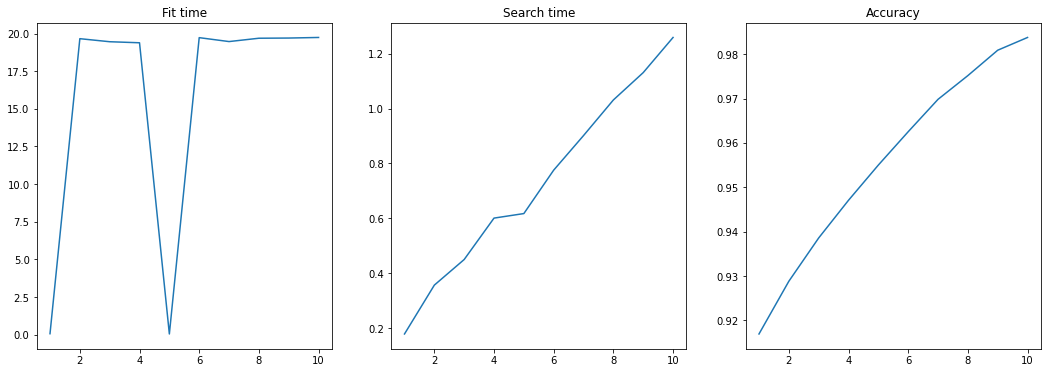

In [ ]:
plt.figure(figsize=[18,6])
plt.subplot(1,3,1)
plt.title('Fit time')

plt.plot(list(r),fit_times)
plt.subplot(1,3,2)
plt.title('Search time')
plt.plot(list(r),search_times)
plt.subplot(1,3,3)
plt.title('Accuracy')
plt.plot(list(r),acc_list)
plt.show()


In [ ]:
#crashed upon size 10**7 
#need to fix this or we can't BM large sets
torch.manual_seed(0)
N, D, K = 10**7, 3, 50

x = 0.7 * torch.randn(N, D, dtype=dtype) + 0.3
y = 0.7 * torch.randn(N, D, dtype=dtype) + 0.3
start=time.time()
t=IVF_flat()
t.fit(x)
print('fit time',time.time()-start)
start=time.time()
t.kneighbors(y)
print('search time:',time.time()-start)